

Discovering Music Moods & Styles with Unsupervised Learning (Spotify Audio Features)

This notebook satisfies the course deliverable for an Unsupervised Learning final project.  
It uses Kaggle's Spotify audio features data to discover interpretable clusters of artists/songs and evaluate them with internal and post‑hoc external metrics.

https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-1921-2020-160k-tracks/data?select=data_w_genres.csv


---

Executive Summary

Given audio features (danceability, energy, valence, tempo, loudness, etc.), can we discover coherent musical groups ("moods/styles") without labels? What are the distinctive characteristics of each group, and how stable are they?  

Approach.
1. Data loading and EDA: inspect distributions, outliers, and correlations; decide on transformations.  
2. Preprocessing: Yeo–Johnson transform + standardization; PCA for visualization and redundancy checks.  
3. Baseline model: K‑Means with model‑selection over k (silhouette, CH, DB).  
4. Advanced models: GMM (BIC), DBSCAN (grid over `eps`, `min_samples`).  
5. Validation: internal metrics; external (post‑hoc) NMI/ARI using a weak proxy label — the first listed genre per artist.  
6. Interpretability: cluster profiles (feature means), top exemplars, and 2‑D plots.  
7. Stability: subsample–repeat test for K‑Means.  



## Setup & Reproducibility

In [6]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, ast, math, random
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
)
from collections import Counter


SEED = 42
np.random.seed(SEED)
random.seed(SEED)


DEFAULT_DIRS = [".", "data", "/mnt/data"]
FILENAMES = {
    "data": "data.csv",
    "data_w_genres": "data_w_genres.csv",
    "by_artist": "data_by_artist.csv",
    "by_genres": "data_by_genres.csv",
    "by_year": "data_by_year.csv",
}

def find_file(name):
    for d in DEFAULT_DIRS:
        p = os.path.join(d, name)
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find {name}. Place it next to the notebook or in a 'data/' folder.")



## Data Loading & Description

We primarily use data_w_genres.csv (track/artist features with an accompanying list of genres).  
Other files are loaded for context/optional analysis:
- data.csv – track-level without genres list
- data_by_artist.csv – per-artist aggregates
- data_by_genres.csv – per-genre aggregates
- data_by_year.csv – per-year aggregates


In [11]:

paths = {k: find_file(v) for k,v in FILENAMES.items() if os.path.exists(find_file(v))}
df = pd.read_csv(paths.get("data_w_genres", paths.get("by_artist", paths.get("data"))))
print({k: paths[k] for k in paths})
print(df.shape)
df.head(3)


{'data': './data.csv', 'data_w_genres': './data_w_genres.csv', 'by_artist': './data_by_artist.csv', 'by_genres': './data_by_genres.csv', 'by_year': './data_by_year.csv'}
(28680, 16)


,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7


## Exploratory Data Analysis (EDA)

In [12]:

df.info()
display(pd.DataFrame({
    "missing_count": df.isna().sum(),
    "dtype": df.dtypes
}).T)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

drop_for_clustering = [c for c in ["year","popularity","key","mode","time_signature"] if c in numeric_cols]
audio_features = [c for c in numeric_cols if c not in drop_for_clustering]
audio_features


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28680 entries, 0 to 28679
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            28680 non-null  object 
 1   artists           28680 non-null  object 
 2   acousticness      28680 non-null  float64
 3   danceability      28680 non-null  float64
 4   duration_ms       28680 non-null  float64
 5   energy            28680 non-null  float64
 6   instrumentalness  28680 non-null  float64
 7   liveness          28680 non-null  float64
 8   loudness          28680 non-null  float64
 9   speechiness       28680 non-null  float64
 10  tempo             28680 non-null  float64
 11  valence           28680 non-null  float64
 12  popularity        28680 non-null  float64
 13  key               28680 non-null  int64  
 14  mode              28680 non-null  int64  
 15  count             28680 non-null  int64  
dtypes: float64(11), int64(3), object(2)
memo

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
missing_count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dtype,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64


['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'count']


### Distributions
We inspect each feature to spot skew, heavy tails, and outliers.


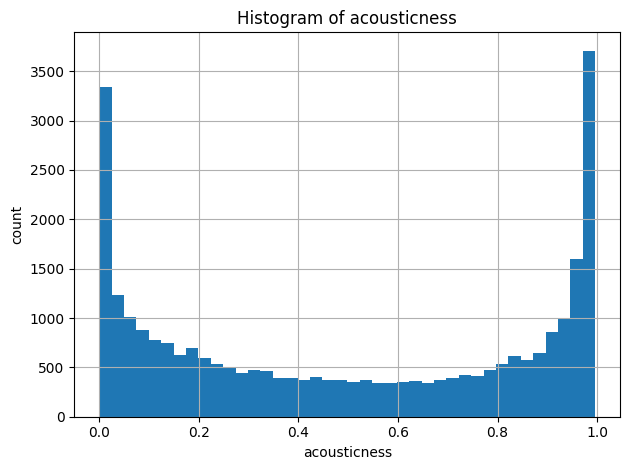

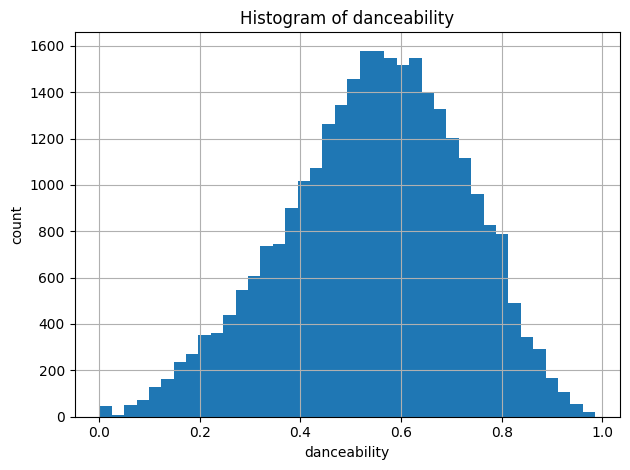

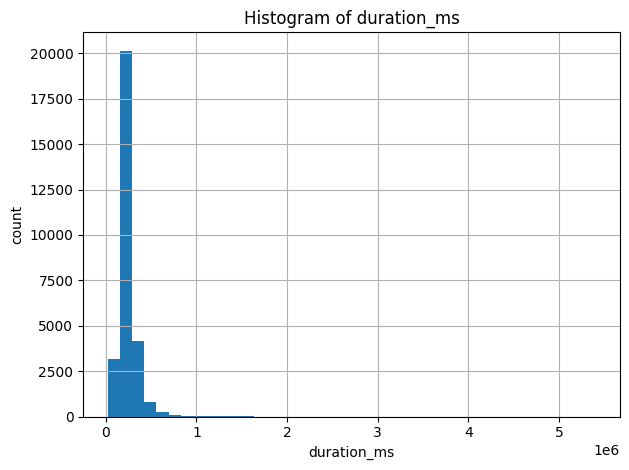

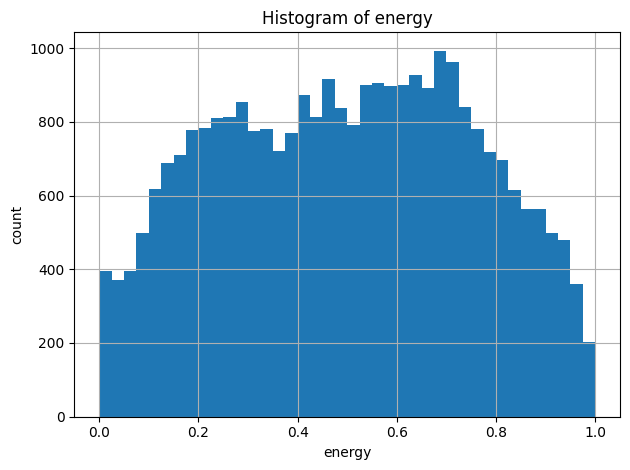

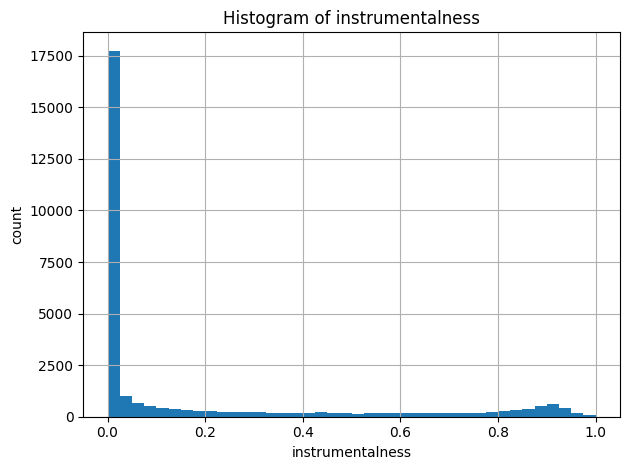

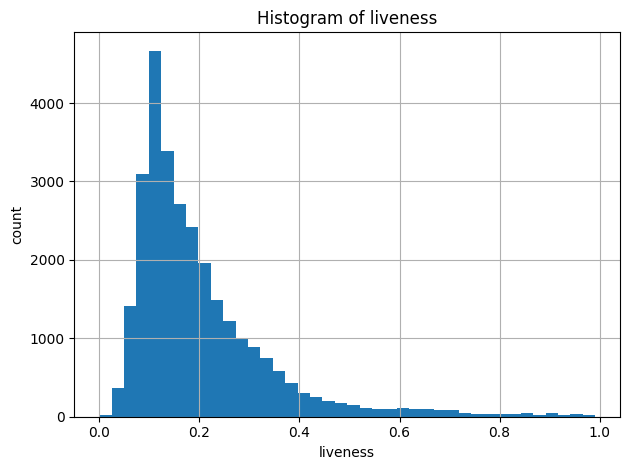

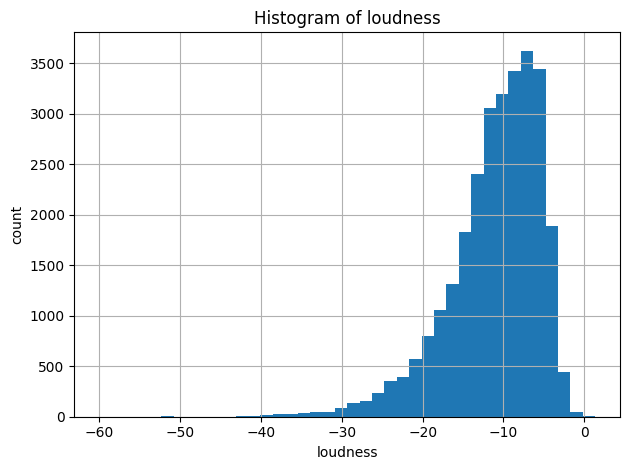

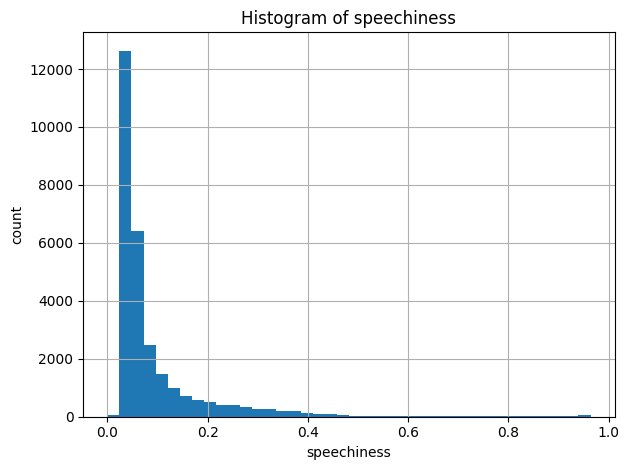

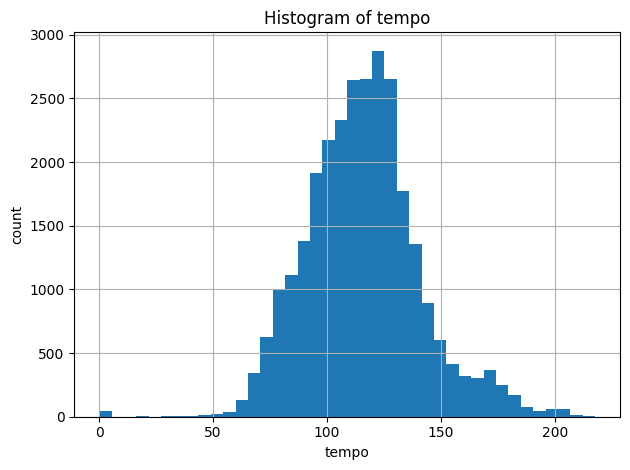

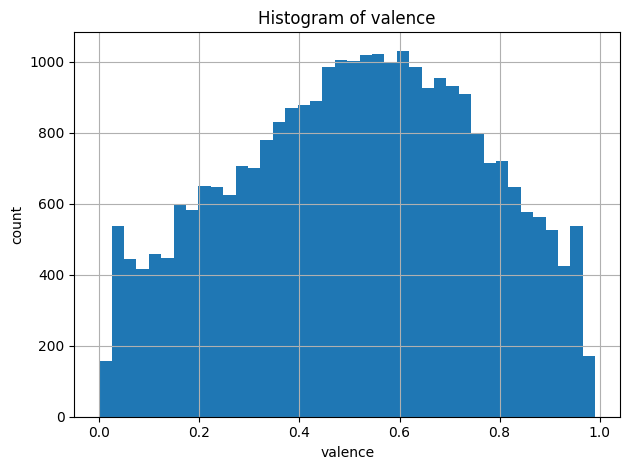

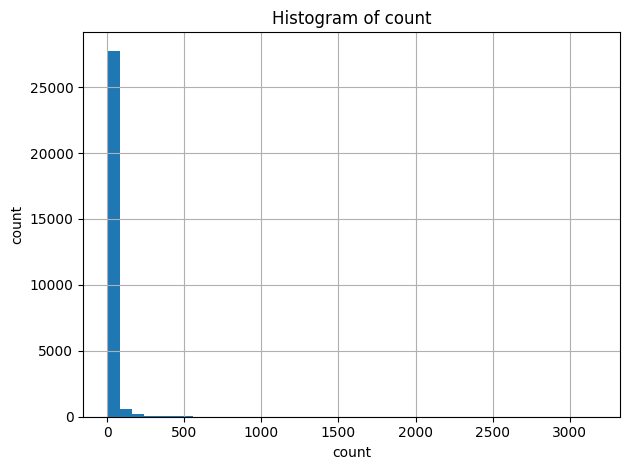

In [5]:

for col in audio_features:
    plt.figure()
    df[col].hist(bins=40)
    plt.xlabel(col); plt.ylabel("count"); plt.title(f"Histogram of {col}")
    plt.tight_layout()
    plt.show()



### Correlations
We examine linear correlations to understand redundancy.


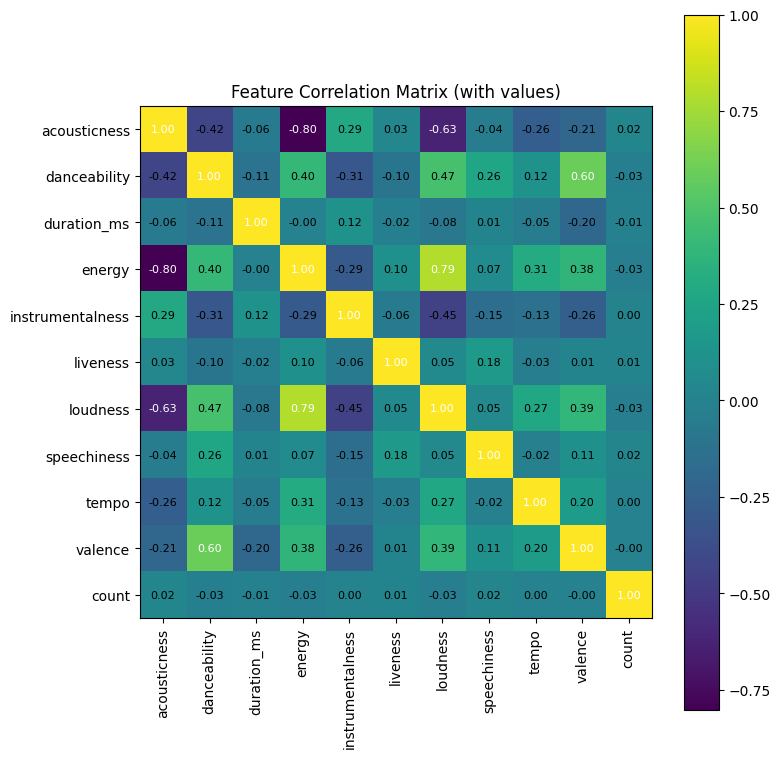

In [14]:

import numpy as np
import matplotlib.pyplot as plt

corr = df[audio_features].corr()

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr, interpolation='nearest') 
ax.set_xticks(np.arange(len(audio_features)))
ax.set_yticks(np.arange(len(audio_features)))
ax.set_xticklabels(audio_features, rotation=90)
ax.set_yticklabels(audio_features)
ax.set_title("Feature Correlation Matrix (with values)")
fig.colorbar(im)


for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        v = corr.iat[i, j]
        
        color = 'white' if abs(v) > 0.5 else 'black'
        ax.text(j, i, f"{v:.2f}", ha='center', va='center', fontsize=8, color=color)

plt.tight_layout()
plt.show()






## Preprocessing & Transformations
We apply Yeo–Johnson (handles zeros/negatives) then standardize. PCA supports visualization and redundancy checks.


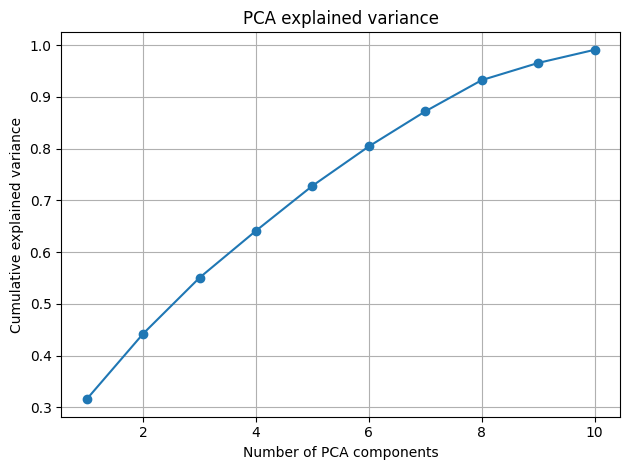

In [15]:

def extract_primary_genre(x):
    try:
        lst = ast.literal_eval(x) if isinstance(x, str) else x
        if isinstance(lst, (list, tuple)) and len(lst) > 0:
            return str(lst[0]).strip().lower()
        return "unknown"
    except Exception:
        return "unknown"

if "genres" in df.columns:
    df["primary_genre"] = df["genres"].apply(extract_primary_genre)
else:
    df["primary_genre"] = "unknown"

X = df[audio_features].copy()

from sklearn.preprocessing import PowerTransformer, StandardScaler
pt = PowerTransformer(method="yeo-johnson")
X_pt = pt.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pt)

from sklearn.decomposition import PCA
pca = PCA(n_components=min(10, X_scaled.shape[1]), random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()

plt.figure()
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel("Number of PCA components"); plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance")
plt.grid(True); plt.tight_layout(); plt.show()

X_2d = X_pca[:, :2]



## Baseline Clustering: K‑Means
We search k in [4, 12] and evaluate internal metrics. 


,k,silhouette,calinski_harabasz,davies_bouldin
0,4,0.126805,4942.227005,2.202642
5,9,0.121289,3136.888754,1.919064
1,5,0.121165,4264.860925,2.133744
2,6,0.118861,3870.173690,2.134770
8,12,0.118134,2673.153451,1.882663
4,8,0.118114,3348.349213,1.973601
6,10,0.118105,2955.766404,1.906610
7,11,0.117350,2802.834307,1.882341
3,7,0.115968,3589.669092,1.992750


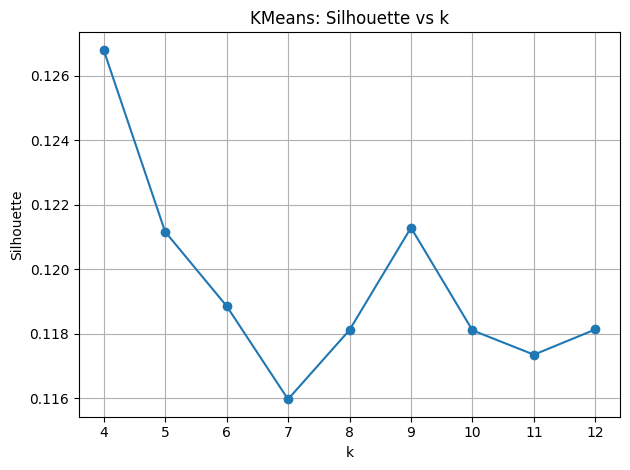

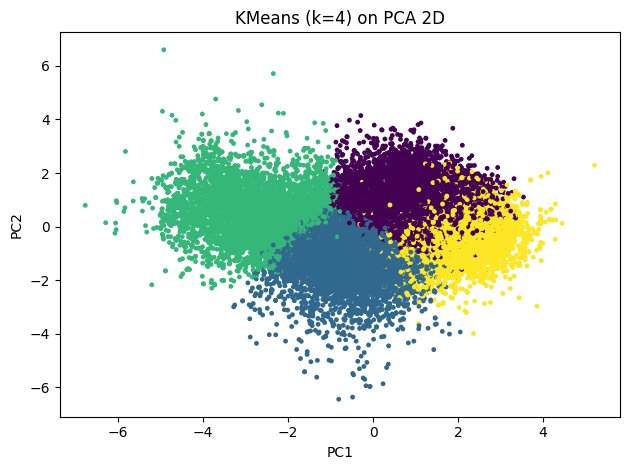

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,count
cluster_kmeans,,,,,,,,,,,
0,0.208,0.561,252043.667,0.677,0.114,0.192,-7.918,0.049,125.065,0.538,15.396
1,0.811,0.564,183120.657,0.351,0.169,0.236,-12.766,0.115,114.300,0.621,16.932
2,0.863,0.335,286001.763,0.205,0.416,0.182,-18.182,0.053,101.003,0.231,13.531
3,0.190,0.715,240705.999,0.696,0.033,0.197,-7.011,0.179,118.433,0.622,7.907


In [17]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_values = list(range(4, 13))
km_rows = []
for k in k_values:
    km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    labels = km.fit_predict(X_scaled)
    km_rows.append({
        "k": k,
        "silhouette": silhouette_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)
    })
km_df = pd.DataFrame(km_rows)
display(km_df.sort_values("silhouette", ascending=False))

plt.figure()
plt.plot(km_df["k"], km_df["silhouette"], marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("KMeans: Silhouette vs k")
plt.grid(True); plt.tight_layout(); plt.show()

best_k = int(km_df.sort_values("silhouette", ascending=False).iloc[0]["k"])
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=SEED)
km_labels = kmeans.fit_predict(X_scaled)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], s=6, c=km_labels)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"KMeans (k={best_k}) on PCA 2D")
plt.tight_layout(); plt.show()

df_km = df.copy()
df_km["cluster_kmeans"] = km_labels
profiles_km = df_km.groupby("cluster_kmeans")[audio_features].mean().round(3)
profiles_km



## Advanced Model 1: Gaussian Mixture (GMM)
We pick components by BIC and report silhouette.


,k,bic,silhouette
4,6,591986.771350,-0.016885
3,5,603823.962693,-0.008949
2,4,621711.498549,0.027044
1,3,632271.251536,0.053991
0,2,756705.563951,0.187301


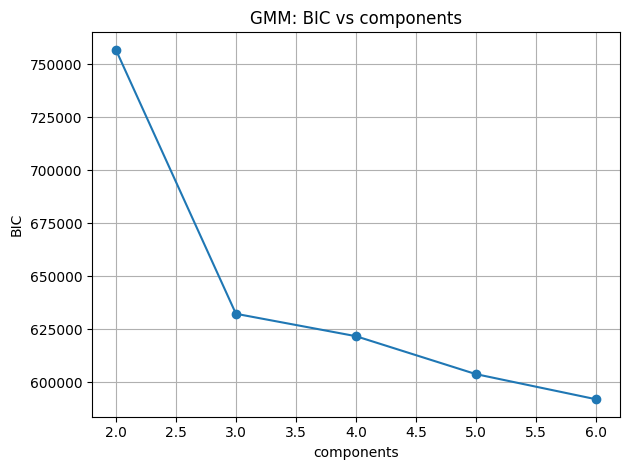

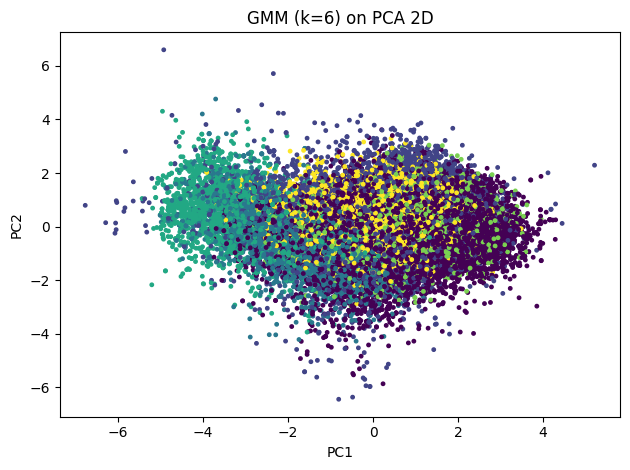

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,count
cluster_gmm,,,,,,,,,,,
0,0.406,0.601,223947.143,0.555,0.000,0.208,-9.024,0.119,118.446,0.560,6.478
1,0.335,0.559,257814.038,0.609,0.363,0.217,-10.640,0.087,119.057,0.498,2.932
2,0.967,0.420,241500.772,0.226,0.236,0.216,-15.548,0.100,103.606,0.420,17.079
3,0.944,0.359,275865.223,0.182,0.826,0.159,-19.971,0.045,104.821,0.309,15.248
4,0.381,0.590,229299.924,0.573,0.002,0.194,-9.348,0.078,118.710,0.563,14.847
5,0.390,0.552,245604.703,0.557,0.176,0.191,-10.440,0.063,119.059,0.549,46.136


In [18]:

from sklearn.mixture import GaussianMixture
gmm_candidates = sorted(set([max(2, best_k-2), best_k-1, best_k, best_k+1, best_k+2]))
best_gmm, best_bic = None, float('inf')
gmm_rows = []
for k in gmm_candidates:
    gmm = GaussianMixture(n_components=k, covariance_type="full", n_init=5, random_state=SEED)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    labels = gmm.predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    gmm_rows.append({"k": k, "bic": bic, "silhouette": sil})
    if bic < best_bic:
        best_bic, best_gmm = bic, gmm

gmm_df = pd.DataFrame(gmm_rows)
display(gmm_df.sort_values("bic"))
plt.figure()
plt.plot(gmm_df["k"], gmm_df["bic"], marker='o')
plt.xlabel("components"); plt.ylabel("BIC"); plt.title("GMM: BIC vs components")
plt.grid(True); plt.tight_layout(); plt.show()

gmm_labels = best_gmm.predict(X_scaled)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], s=6, c=gmm_labels)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"GMM (k={best_gmm.n_components}) on PCA 2D")
plt.tight_layout(); plt.show()

df_gmm = df.copy()
df_gmm["cluster_gmm"] = gmm_labels
profiles_gmm = df_gmm.groupby("cluster_gmm")[audio_features].mean().round(3)
profiles_gmm



## Advanced Model 2: DBSCAN (Density-Based)
We sweep eps and min_samples and report the best masked-silhouette.


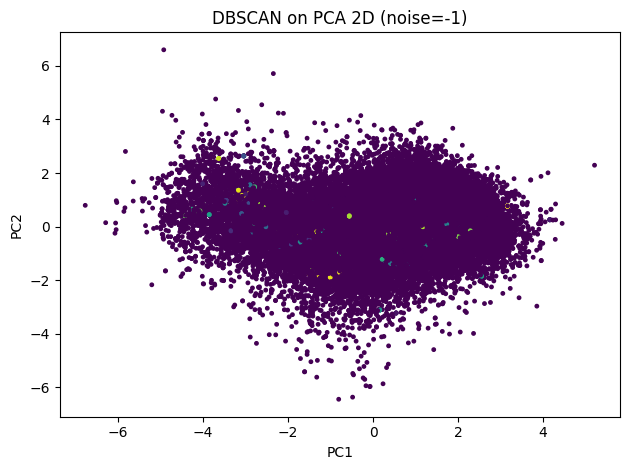

(589, np.float64(0.8631484874732454))

In [19]:

from sklearn.cluster import DBSCAN
eps_grid = [0.5, 0.75, 1.0, 1.25, 1.5]
min_samples_grid = [5, 10, 20]
best_dbscan, best_db_sil, best_db_labels = None, -1.0, None
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        mask = labels != -1
        if mask.sum() < 200:
            continue
        try:
            sil = silhouette_score(X_scaled[mask], labels[mask])
        except Exception:
            sil = -1.0
        if sil > best_db_sil:
            best_db_sil, best_dbscan, best_db_labels = sil, db, labels

if best_db_labels is None:
    dbscan_labels = np.full(len(df), -1)
else:
    dbscan_labels = best_db_labels

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], s=6, c=np.where(dbscan_labels==-1, -1, dbscan_labels))
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("DBSCAN on PCA 2D (noise=-1)")
plt.tight_layout(); plt.show()

db_kept = int((dbscan_labels!=-1).sum())
db_kept, best_db_sil



## Post‑hoc External Validation with Genres
We compute NMI and ARI using the first listed genre per entity as a weak label.


In [20]:

y_enc = df["primary_genre"].astype("category").cat.codes.values
summary_metrics = pd.DataFrame([
    {
        "model": "KMeans",
        "k/components": best_k,
        "silhouette": silhouette_score(X_scaled, km_labels),
        "NMI_vs_primary_genre": normalized_mutual_info_score(y_enc, km_labels),
        "ARI_vs_primary_genre": adjusted_rand_score(y_enc, km_labels)
    },
    {
        "model": "GMM",
        "k/components": best_gmm.n_components,
        "silhouette": silhouette_score(X_scaled, gmm_labels),
        "NMI_vs_primary_genre": normalized_mutual_info_score(y_enc, gmm_labels),
        "ARI_vs_primary_genre": adjusted_rand_score(y_enc, gmm_labels)
    }
])
summary_metrics


,model,k/components,silhouette,NMI_vs_primary_genre,ARI_vs_primary_genre
0,KMeans,4,0.126805,0.153453,0.024021
1,GMM,6,-0.016885,0.140493,0.013129



## Stability Test for K‑Means
Subsample 80% five times and compute pairwise ARI on overlaps.


In [21]:

from sklearn.metrics import adjusted_rand_score
def run_kmeans(X, k, seed):
    return KMeans(n_clusters=k, n_init=20, random_state=seed).fit_predict(X)

runs = []
indices_list = []
for i in range(5):
    rng = np.random.RandomState(42+i)
    idx = rng.choice(len(X_scaled), size=int(0.8*len(X_scaled)), replace=False)
    labels_i = run_kmeans(X_scaled[idx], best_k, 42+i)
    runs.append(labels_i)
    indices_list.append(idx)

aris = []
for i in range(len(runs)):
    for j in range(i+1, len(runs)):
        overlap = np.intersect1d(indices_list[i], indices_list[j])
        if len(overlap) < 100: 
            continue
        map_i = {v:k for k,v in enumerate(indices_list[i])}
        map_j = {v:k for k,v in enumerate(indices_list[j])}
        li = runs[i][[map_i[o] for o in overlap]]
        lj = runs[j][[map_j[o] for o in overlap]]
        aris.append(adjusted_rand_score(li, lj))

pd.Series(aris, name="Subsample ARI (KMeans)").describe()


count    10.000000
mean      0.848638
std       0.076703
min       0.738497
25%       0.801143
50%       0.846159
75%       0.910018
max       0.963854
Name: Subsample ARI (KMeans), dtype: float64


## Save Artifacts
We save cluster assignments and cluster-mean profiles.


In [22]:

out_assign = "artist_clusters_kmeans.csv"
out_profiles = "cluster_profiles_kmeans.csv"
(
    df_km[["artists", "primary_genre", "cluster_kmeans"]]
    if "artists" in df_km.columns else
    df_km[["primary_genre", "cluster_kmeans"]]
).to_csv(out_assign, index=False)
profiles_km.to_csv(out_profiles, index=True)
out_assign, out_profiles


('artist_clusters_kmeans.csv', 'cluster_profiles_kmeans.csv')